## ACS PUMS: recent adult datasets

How to use folktables please refer to https://github.com/socialfoundations/folktables.git
- e.g. the defination of adult_filter can be found at https://github.com/socialfoundations/folktables/blob/main/folktables/acs.py

<span style="color:red">Quick note about the tool:</span>
The original paper (https://arxiv.org/pdf/2108.04884v3) provides detailed descriptions of datasets like ACSIncome and ACSEmployment, including their specific features and filter conditions.

**The ```ACSIncome``` function:**
1. comes with default configurations:
- Features(float): AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
- Labels(boolean): PINCP

2. ```adult_filter``` criteria:
- AGEP (Age): Must be greater than 16
- PINCP (Total person’s income): Must be greater than 100
- WKHP (Usual hours worked per week past 12 months): Must be greater than 0
- PWGTP (Person weight (relevant for re-weighting dataset to represent the general US population most accurately)): Must be greater than or equal to 1

**The ```ACSEmployment``` function:**
1. comes with default configurations:
- Features(float):'AGEP','SCHL','MAR','SEX','DIS','ESP','MIG','CIT','MIL','ANC','NATIVITY','RELP','DEAR','DEYE','DREM','RAC1P','GCL'
- Labels(boolean):'ESR'
- **The label should be <span style="color:red">'ESR'</span>**. According to the documentation, the feature ‘NWLA’ (On layoff from work) is UNEDITED – see ‘Employment Status Recode’ (ESR).
2. ```employment_filter``` criteria:
- AGEP (Age) must be greater than 16 and less than 90.
- PWGTP (Person weight) must be greater than or equal to 1.

In both datasets, **we dropped the ‘RELP’ feature** because it is not available in the 2023 dataset, and we want to ensure that all features are consistent across years. See code below.

## Data Preprocessing


### Assign OCCP Top-Level Category

In [1]:
import requests
import pandas as pd

# API URL of OCCP "Occupation"
url_2014 = "https://api.census.gov/data/2014/acs/acs1/pums/variables/OCCP.json"
url_2023 = "https://api.census.gov/data/2023/acs/acs1/pums/variables/OCCP.json"
response_2014 = requests.get(url_2014)
response_2023 = requests.get(url_2023)
data_2014 = response_2014.json()
data_2023 = response_2023.json()

# OCCP
print(data_2014['label'])
print(data_2023['label'])

dict_2014 = data_2014['values']['item']
dict_2023 = data_2023['values']['item']
# Merging the two dictionaries and cover
# Keys present in both 2014 and 2023 are updated with 2023 values.
values_dict = {**dict_2014, **dict_2023}

df_OCCP = pd.DataFrame.from_dict(values_dict, orient='index', columns=['explanation'])
df_OCCP = df_OCCP.reset_index().rename(columns={'index': 'code'})
df_OCCP = df_OCCP[df_OCCP['code'] != 'N']
df_OCCP['code'] = df_OCCP['code'].astype(float)
# Extracting the first word as the category if it exists, otherwise set it to None
df_OCCP['category_prefix'] = df_OCCP['explanation'].str.extract(r'^([^-\s]+)-')

# Full Name Mapping
prefix_dict = {
    "MGR": "Manager",
    "OFF": "Office and Administrative Support",
    "EAT": "Food Preparation and Serving Related",
    "PRD": "Production",
    "TRN": "Transportation and Material Moving",
    "CMS": "Community and Social Service",
    "BUS": "Business and Financial Operations",
    "ENG": "Engineers",
    "SCI": "Scientists",
    "MED": "Healthcare Practitioners and Technical",
    "HLS": "Healthcare Support",
    "PRT": "Protective Service",
    "EDU": "Education, Training, and Library",
    "ENT": "Arts, Design, Entertainment, Sports, and Media",
    "LGL": "Legal",
    "SAL": "Sales and Related",
    "PRS": "Personal Care and Service",
    "CLN": "Building and Grounds Cleaning and Maintenance",
    "CON": "Construction and Extraction",
    "RPR": "Installation, Maintenance, and Repair",
    "FFF": "Farming, Fishing, and Forestry",
    "CMM": "Computer and Mathematical",
    "FIN": "Financial Specialists",
    "EXT": "Extraction Workers",
    "MIL": "Military Specific"
}

prefix_code_dict = {k: i for i, k in enumerate(prefix_dict.keys())}
df_OCCP['category_code'] = df_OCCP['category_prefix'].map(prefix_code_dict)
df_OCCP['category_name'] = df_OCCP['category_prefix'].map(prefix_dict)

print(df_OCCP.head())
print("Size of df_OCCP: ", df_OCCP.shape)

Occupation recode for 2012 and later based on 2010 OCC codes
Occupation recode for 2018 and later based on 2018 OCC codes
     code                                explanation category_prefix  \
0  2000.0                             CMS-COUNSELORS             CMS   
1  3160.0                    MED-Physical Therapists             MED   
2  3820.0  PRT-Detectives And Criminal Investigators             PRT   
3  5200.0                       OFF-BROKERAGE CLERKS             OFF   
4  5220.0   OFF-Court, Municipal, And License Clerks             OFF   

   category_code                           category_name  
0            5.0            Community and Social Service  
1            9.0  Healthcare Practitioners and Technical  
2           11.0                      Protective Service  
3            1.0       Office and Administrative Support  
4            1.0       Office and Administrative Support  
Size of df_OCCP:  (631, 5)


In [2]:
df_OCCP.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631 entries, 0 to 631
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             631 non-null    float64
 1   explanation      631 non-null    object 
 2   category_prefix  629 non-null    object 
 3   category_code    629 non-null    float64
 4   category_name    629 non-null    object 
dtypes: float64(2), object(3)
memory usage: 29.6+ KB


In [3]:
df_OCCP[['category_prefix', 'category_code']].drop_duplicates()

,category_prefix,category_code
0,CMS,5.0
1,MED,9.0
2,PRT,11.0
3,OFF,1.0
5,TRN,4.0
7,CON,18.0
8,NaN,NaN
9,FIN,22.0
10,HLS,10.0
11,MIL,24.0


### Require Data

In [4]:
from folktables import ACSDataSource, ACSIncome, ACSEmployment, BasicProblem, adult_filter, employment_filter
import numpy as np

# Dropping 'RELP' since it is not available in 2023 dataset
ACSIncomeNew = BasicProblem( 
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'OCCP',
        'POBP',
        'WKHP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 50000,    
    group='RAC1P',
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

ACSEmploymentNew = BasicProblem(
    features=[
        'AGEP',
        'SCHL',
        'MAR',
        'SEX',
        'DIS',
        'ESP',
        'MIG',
        'CIT',
        'MIL',
        'ANC',
        'NATIVITY',
        'DEAR',
        'DEYE',
        'DREM',
        'RAC1P',
        'GCL',
    ],
    target="ESR",
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

data_source_2014 = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data_2014 = data_source_2014.get_data(states=["CA"], download=True) # California

data_source_2023 = ACSDataSource(survey_year='2023', horizon='1-Year', survey='person')
ca_data_2023 = data_source_2023.get_data(states=["CA"], download=True) # California

In [5]:
# Income Data
ca_features_2023, ca_labels_2023, _ = ACSIncomeNew.df_to_pandas(ca_data_2023)
ca_features_2014, ca_labels_2014, _ = ACSIncomeNew.df_to_pandas(ca_data_2014)

# Employment Data
ca_features_2014_em, ca_labels_2014_em, _ = ACSEmploymentNew.df_to_pandas(ca_data_2014)
ca_features_2023_em, ca_labels_2023_em, _ = ACSEmploymentNew.df_to_pandas(ca_data_2023)

# True 1 False 0, 1 = > 50K, 0 = <= 50K
mapping = {True: 1, False: 0}
# Income labels
ca_labels_2014['PINCP'] = ca_labels_2014['PINCP'].map(mapping)
ca_labels_2023['PINCP'] = ca_labels_2023['PINCP'].map(mapping)
# Employment labels
ca_labels_2023_em['ESR'] = ca_labels_2023_em['ESR'].map(mapping)
ca_labels_2014_em['ESR'] = ca_labels_2014_em['ESR'].map(mapping)

In [6]:
# Checking for missing values in the features
missing_count = ca_features_2014.isna().sum()
print("2014 missing data\n",missing_count)

missing_count = ca_features_2023.isna().sum()
print("2023 missing data\n",missing_count)

2014 missing data
 AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64
2023 missing data
 AGEP     0
COW      0
SCHL     0
MAR      0
OCCP     0
POBP     0
WKHP     0
SEX      0
RAC1P    0
dtype: int64


#### Mapping Occupation Codes to Occupation Categories

In [7]:
"""Needs to use these features for the analysis of employment"""
ca_features_2014_merged = ca_features_2014.merge(df_OCCP[['code', 'category_code']], 
                            left_on='OCCP', right_on='code', how='left').drop(columns=['code']).rename(columns={'category_code': 'OCCP_CA'})
ca_features_2023_merged = ca_features_2023.merge(df_OCCP[['code', 'category_code']],
                            left_on='OCCP', right_on='code', how='left').drop(columns=['code']).rename(columns={'category_code': 'OCCP_CA'})

In [8]:
ca_features_2014_merged

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,OCCP_CA
0,36.0,1.0,16.0,5.0,9610.0,22.0,35.0,1.0,1.0,4.0
1,47.0,1.0,20.0,3.0,5700.0,39.0,60.0,2.0,1.0,1.0
2,20.0,1.0,19.0,5.0,4840.0,6.0,40.0,1.0,1.0,15.0
3,31.0,1.0,19.0,1.0,5120.0,6.0,45.0,2.0,1.0,1.0
4,31.0,5.0,19.0,1.0,5550.0,6.0,40.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
183936,63.0,1.0,19.0,3.0,4720.0,313.0,40.0,2.0,8.0,15.0
183937,38.0,3.0,20.0,5.0,3320.0,6.0,40.0,1.0,8.0,9.0
183938,40.0,1.0,21.0,1.0,6440.0,6.0,30.0,2.0,1.0,18.0
183939,40.0,3.0,20.0,1.0,3740.0,6.0,56.0,1.0,1.0,11.0


In [9]:
result = (ca_features_2014_merged.groupby('OCCP_CA').size().reset_index(name='Count')
          .sort_values('Count', ascending=False).reset_index(drop=True))
print(len(ca_features_2014_merged))
print(result)

183941
    OCCP_CA  Count
0       1.0  23420
1      15.0  19227
2       0.0  19144
3      12.0  11307
4       4.0  10452
5       2.0   9669
6       3.0   9438
7       9.0   9259
8      16.0   8458
9      18.0   7948
10     17.0   7133
11     21.0   5916
12     13.0   5711
13      6.0   5241
14     19.0   4794
15     22.0   4364
16      7.0   3988
17     11.0   3781
18     10.0   3322
19     20.0   3144
20      5.0   2951
21     14.0   2382
22      8.0   2101
23     24.0    660
24     23.0    131


In [10]:
result = (ca_features_2023_merged.groupby('OCCP_CA').size().reset_index(name='Count')
          .sort_values('Count', ascending=False).reset_index(drop=True))
print(len(ca_features_2023_merged))
print(result)

203278
    OCCP_CA  Count
0       0.0  23611
1       1.0  20052
2      15.0  17271
3       4.0  14141
4      12.0  12942
5       9.0  11375
6       2.0  10468
7      21.0   9386
8       3.0   8355
9      18.0   8125
10      6.0   8102
11     10.0   7579
12     13.0   6754
13     17.0   6660
14      7.0   5730
15     16.0   5656
16     19.0   4999
17     22.0   4489
18     11.0   3946
19      5.0   3608
20      8.0   3354
21     20.0   2747
22     14.0   2722
23     24.0   1102
24     23.0    104


## Data Analysis: Bias in Income Prediction

### Helper functions

In [11]:
def calculate_fairness_metrics(df, y_pred, y_true, sensitive_attribute):
    df = df.copy()
    df["pred"] = pd.Series(y_pred).values
    df["true"] = y_true

    group_probabilities = {}
    group_fprs = {}
    group_tprs = {}
    unique_groups = sorted(df[sensitive_attribute].unique())

    for group_val in unique_groups:
        group_df = df[df[sensitive_attribute] == group_val]
        
        # Calculate probability of positive prediction (for Demographic Parity)
        prob_favorable_pred = (group_df["pred"] == 1).mean()
        group_probabilities[f"P(pred=1 | {sensitive_attribute}={group_val})"] = prob_favorable_pred
        
        # Calculate False Positive Rate
        true_negatives = group_df[group_df["true"] == 0]
        fpr = (true_negatives["pred"] == 1).mean() if len(true_negatives) > 0 else 0
        group_fprs[f"FPR | {sensitive_attribute}={group_val}"] = fpr

        # Calculate True Positive Rate
        true_positives = group_df[group_df["true"] == 1]
        tpr = (true_positives["pred"] == 1).mean() if len(true_positives) > 0 else 0
        group_tprs[f"TPR | {sensitive_attribute}={group_val}"] = tpr

    # Calculate differences
    probs = list(group_probabilities.values())
    demographic_parity_diff = max(probs) - min(probs)
    
    fprs = list(group_fprs.values())
    fpr_diff = max(fprs) - min(fprs)
    
    tprs = list(group_tprs.values())
    tpr_diff = max(tprs) - min(tprs)

    results = {
        "Demographic Parity Difference Maximum": demographic_parity_diff,
        "FPR Difference Maximum": fpr_diff,
        "TPR Difference Maximum": tpr_diff,
        **group_probabilities,
        **group_fprs,
        **group_tprs
    }

    return results

In [12]:
# Overall distribution of income in 2023
print(len(ca_labels_2023))
print('Race distribution of income in 2023\n')
race_counts = ca_features_2023['RAC1P'].value_counts()
race_percents = ca_features_2023['RAC1P'].value_counts(normalize=True) * 100
print(pd.concat([race_counts, race_percents], axis=1, keys=['Count', 'Percentage']))

print('\nSEX distribution of income in 2023\n')
sex_counts = ca_features_2023['SEX'].value_counts()
sex_percents = ca_features_2023['SEX'].value_counts(normalize=True) * 100
print(pd.concat([sex_counts, sex_percents], axis=1, keys=['Count', 'Percentage']))

print('\nMarital Status distribution of income in 2023\n')
mar_counts = ca_features_2023['MAR'].value_counts()
mar_percents = ca_features_2023['MAR'].value_counts(normalize=True) * 100
print(pd.concat([mar_counts, mar_percents], axis=1, keys=['Count', 'Percentage']))

# ca_features_2023, ca_labels_2023,
# ca_features_2014, ca_labels_2014,

203278
Race distribution of income in 2023

       Count  Percentage
RAC1P                   
1.0    83884   41.265656
6.0    38037   18.711813
8.0    34916   17.176478
9.0    34243   16.845404
2.0     8205    4.036344
3.0     2708    1.332166
5.0      653    0.321235
7.0      616    0.303033
4.0       16    0.007871

SEX distribution of income in 2023

      Count  Percentage
SEX                    
1.0  107128   52.700243
2.0   96150   47.299757

Marital Status distribution of income in 2023

      Count  Percentage
MAR                    
1.0  103089   50.713309
5.0   75940   37.357707
3.0   17194    8.458367
2.0    3588    1.765070
4.0    3467    1.705546


### 1st Sensitive Attribute: Sex

In [13]:
import pandas as pd
import requests

df_income_14 = pd.concat([ca_features_2023, ca_labels_2023], axis=1) # Pay attention to the year!!

fairness_distribution = (
    df_income_14.groupby('SEX')['PINCP']
    .agg(
        Count=lambda x: (x == 1).sum(),          # Number of high-income individuals among the group
        Percentage=lambda x: (x == 1).mean() * 100  # Percentage of high-income individuals among the group
    )
    .reset_index()
    .sort_values('SEX')
)

url = "https://api.census.gov/data/2014/acs/acs1/pums/variables/SEX.json"
response = requests.get(url)
data = response.json()

values_dict = data['values']['item']
df_race_labels = pd.DataFrame.from_dict(values_dict, orient='index', columns=['explanation'])
df_race_labels = df_race_labels.reset_index().rename(columns={'index': 'code'})
df_race_labels['code'] = df_race_labels['code'].astype(float)


fairness_distribution_merged = fairness_distribution.merge(
    df_race_labels[['code', 'explanation']],
    left_on='SEX', right_on='code',
    how='left'
).drop(columns=['code'])


fairness_distribution_merged = fairness_distribution_merged.rename(columns={
    'SEX': 'SEX_Code',
    'explanation': 'SEX_Description',
    'Count': 'High_Income_Count',
    'Percentage': 'High_Income_Percentage'
})

fairness_distribution_merged['High_Income_Percentage'] = (
    fairness_distribution_merged['High_Income_Percentage'].round(2)
)

fairness_distribution_merged

,SEX_Code,High_Income_Count,High_Income_Percentage,SEX_Description
0,1.0,58217,54.34,Male
1,2.0,43105,44.83,Female


### Train model

#### Split traning  and test: did not change the name of variables beacaue it is too many but they are from data of 2023

In [14]:
from sklearn.model_selection import train_test_split

x_14_income_train, x_14_income_test, y_14_income_train, y_14_income_test = train_test_split(ca_features_2023, ca_labels_2023, test_size=0.2, random_state=42)

#### Regular Model

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Train the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(x_14_income_train, y_14_income_train)

# predict on the test set
y_pred = model.predict(x_14_income_test)

# evaluate the model
acc = accuracy_score(y_14_income_test, y_pred)
f1 = f1_score(y_14_income_test, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)

# confusion matrix
cm = confusion_matrix(y_14_income_test, y_pred)
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])
print("\nConfusion Matrix in Table Form:")
print(cm_df)
print("TP (True Positive):", tp)
print("FP (False Positive):", fp)
print("TN (True Negative):", tn)
print("FN (False Negative):", fn)

tpr = tp / (tp + fn)  # TPR
fpr = fp / (fp + tn)  # FPR

print("\nTPR (True Positive Rate/Recall):", tpr)
print("FPR (False Positive Rate):", fpr)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8160911058638332
F1 Score: 0.8172463520152519

Confusion Matrix in Table Form:
                 Predicted Negative  Predicted Positive
Actual Negative               16461                4050
Actual Positive                3427               16718
TP (True Positive): 16718
FP (False Positive): 4050
TN (True Negative): 16461
FN (False Negative): 3427

TPR (True Positive Rate/Recall): 0.8298833457433606
FPR (False Positive Rate): 0.19745502413339183


##### No parameter tuning is needed, because he model's performance is already stable (metrics show low standard deviation). 

In [16]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'f1', 'recall', 'precision']


cv_results = cross_validate(model, x_14_income_train, y_14_income_train,
                          cv=5, scoring=scoring)


for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric}: AVG {scores.mean():.4f} (±{scores.std():.4f})")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

accuracy: AVG 0.8149 (±0.0019)
f1: AVG 0.8168 (±0.0015)
recall: AVG 0.8267 (±0.0021)
precision: AVG 0.8072 (±0.0036)


#### SHAP

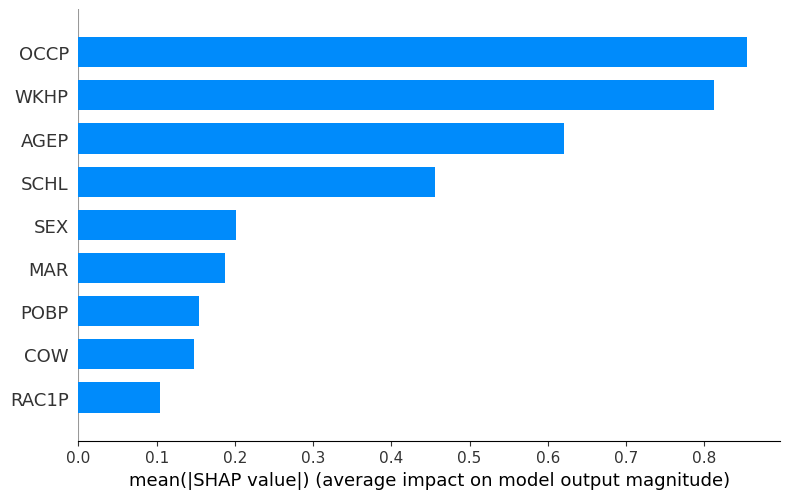

In [17]:
import xgboost
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_14_income_test)
shap.summary_plot(shap_values, x_14_income_test, plot_type="bar")

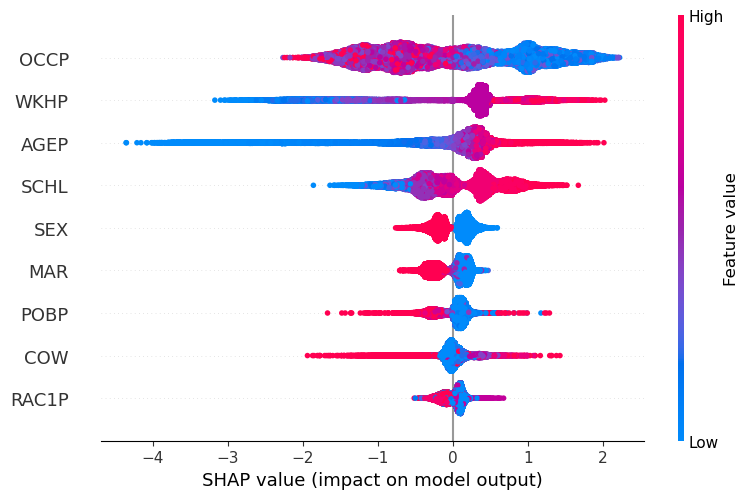

In [18]:
shap.summary_plot(shap_values, x_14_income_test)
# shap.dependence_plot("RAC1P", shap_values, x_14_income_test)

In [20]:
result = calculate_fairness_metrics(x_14_income_test, y_pred, y_14_income_test,sensitive_attribute='SEX')
for key, value in result.items():
    print(f"{key}: {value:.4f}")

Demographic Parity Difference Maximum: 0.1055
FPR Difference Maximum: 0.0620
TPR Difference Maximum: 0.0265
P(pred=1 | SEX=1.0): 0.5607
P(pred=1 | SEX=2.0): 0.4552
FPR | SEX=1.0: 0.2298
FPR | SEX=2.0: 0.1677
TPR | SEX=1.0: 0.8411
TPR | SEX=2.0: 0.8146


#### Without the protected attribute

In [21]:
# Train the model
model_2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
x_14_income_norace_train = x_14_income_train.drop(["SEX"], axis=1)
model_2.fit(x_14_income_norace_train, y_14_income_train)

# predict on the test set

x_14_income_norace_test = x_14_income_test.drop(["SEX"], axis=1)
y_norace_pred = model_2.predict(x_14_income_norace_test)

# evaluate the model
acc = accuracy_score(y_14_income_test, y_norace_pred)
f1 = f1_score(y_14_income_test, y_norace_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)

# confusion matrix
cm = confusion_matrix(y_14_income_test, y_norace_pred)
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])
print("\nConfusion Matrix in Table Form:")
print(cm_df)
print("TP (True Positive):", tp)
print("FP (False Positive):", fp)
print("TN (True Negative):", tn)
print("FN (False Negative):", fn)

tpr = tp / (tp + fn)  # TPR
fpr = fp / (fp + tn)  # FPR

print("\nTPR (True Positive Rate/Recall):", tpr)
print("FPR (False Positive Rate):", fpr)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8153040141676505
F1 Score: 0.8161406429813178

Confusion Matrix in Table Form:
                 Predicted Negative  Predicted Positive
Actual Negative               16481                4030
Actual Positive                3479               16666
TP (True Positive): 16666
FP (False Positive): 4030
TN (True Negative): 16481
FN (False Negative): 3479

TPR (True Positive Rate/Recall): 0.8273020600645321
FPR (False Positive Rate): 0.1964799375944615


In [22]:
result = calculate_fairness_metrics(x_14_income_test, y_norace_pred, y_14_income_test,sensitive_attribute='SEX')
for key, value in result.items():
    print(f"{key}: {value:.4f}")

Demographic Parity Difference Maximum: 0.0680
FPR Difference Maximum: 0.0275
TPR Difference Maximum: 0.0146
P(pred=1 | SEX=1.0): 0.5412
P(pred=1 | SEX=2.0): 0.4732
FPR | SEX=1.0: 0.2108
FPR | SEX=2.0: 0.1833
TPR | SEX=1.0: 0.8211
TPR | SEX=2.0: 0.8357


#### Pre-processing: Reweighing
Train and test a classifier with weights (see lecture slide for the weight calculation)

In [58]:
# W（X）= P_exp（A，Y）/P_obs（A，Y）
def calculate_weights(df, sensitive_attr, target_attr):
    P_A = df.groupby(sensitive_attr).size() / len(df)
    P_Y = df[target_attr].value_counts(normalize=True)
    
    # P_exp(A,Y) = P(A) * P(Y)
    P_exp = {}
    for a in P_A.index:
        for y in P_Y.index:
            P_exp[(a, y)] = P_A[a] * P_Y[y]
    
    # P_obs(A,Y)
    P_obs = df.groupby([sensitive_attr, target_attr]).size() / len(df)

    # print("\nP_exp(A,Y):")
    # for key, value in P_exp.items():
    #     print(f"{key}: {value:.4f}")
    
    # print("\nP_obs(A,Y):")
    # for key, value in P_obs.items():
    #     print(f"{key}: {value:.4f}")
    
    print("\nWeight = P_exp / P_obs:")
    for key in P_exp:
        obs = P_obs.get(key)
        print(f"{key}: {P_exp[key]/obs:.4f}")
    
    df['weight'] = df.apply(
        lambda row: P_exp[(row[sensitive_attr], row[target_attr])] / P_obs.get((row[sensitive_attr], row[target_attr]), 1), 
        axis=1
    )
    
    return df
    

compas_data_weighted = calculate_weights(df_income_14, "SEX", "PINCP")


# Train the model with weighted data
model_3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_3.fit(x_14_income_train, y_14_income_train, sample_weight=compas_data_weighted.loc[x_14_income_train.index, "weight"])

# predict on the test set
y_pred_weight = model_3.predict(x_14_income_test)

# evaluate the model
acc = accuracy_score(y_14_income_test, y_pred_weight)
f1 = f1_score(y_14_income_test, y_pred_weight)

print("Accuracy:", acc)
print("F1 Score:", f1)

# confusion matrix
cm = confusion_matrix(y_14_income_test, y_pred_weight)
tn, fp, fn, tp = cm.ravel()

cm_df = pd.DataFrame(cm, 
                     index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])
print("\nConfusion Matrix in Table Form:")
print(cm_df)
print("TP (True Positive):", tp)
print("FP (False Positive):", fp)
print("TN (True Negative):", tn)
print("FN (False Negative):", fn)

tpr = tp / (tp + fn)  # TPR
fpr = fp / (fp + tn)  # FPR

print("\nTPR (True Positive Rate/Recall):", tpr)
print("FPR (False Positive Rate):", fpr)


Weight = P_exp / P_obs:
(1.0, 0): 1.0985
(1.0, 1): 0.9172
(2.0, 0): 0.9091
(2.0, 1): 1.1118


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8160665092483275
F1 Score: 0.8169041672787817

Confusion Matrix in Table Form:
                 Predicted Negative  Predicted Positive
Actual Negative               16496                4015
Actual Positive                3463               16682
TP (True Positive): 16682
FP (False Positive): 4015
TN (True Negative): 16496
FN (False Negative): 3463

TPR (True Positive Rate/Recall): 0.828096301811864
FPR (False Positive Rate): 0.19574862269026377


In [59]:
result = calculate_fairness_metrics(x_14_income_test, y_pred_weight, y_14_income_test,sensitive_attribute='SEX')
for key, value in result.items():
    print(f"{key}: {value:.4f}")

Demographic Parity Difference Maximum: 0.0528
FPR Difference Maximum: 0.0100
TPR Difference Maximum: 0.0278
P(pred=1 | SEX=1.0): 0.5341
P(pred=1 | SEX=2.0): 0.4812
FPR | SEX=1.0: 0.2010
FPR | SEX=2.0: 0.1910
TPR | SEX=1.0: 0.8163
TPR | SEX=2.0: 0.8441


#### Post-processing: Equalized odd
Use the predictions by the first classifier for this post processing part

In [56]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import equalized_odds_difference, true_positive_rate_difference, false_positive_rate_difference

# Initialize the postprocessor with the trained model with constraints Equalized Odds
postprocessor = ThresholdOptimizer(
    estimator = model,  # First classifier: regular model
    constraints = "equalized_odds",
    objective = "balanced_accuracy_score",  # Objective function to optimize
    prefit=True,
    predict_method="predict_proba"
)
sensitive_series_train = x_14_income_train['SEX'].copy()
sensitive_series_train.name = "SEX" 
y_14_income_train_series = y_14_income_train['PINCP']
y_14_income_test_series = y_14_income_test['PINCP']


sensitive_series_test = x_14_income_test['SEX'].copy()
sensitive_series_test.name = "SEX"

# p_00, p_01, p_10, p_11
postprocessor.fit(x_14_income_train, y_14_income_train_series, sensitive_features=sensitive_series_train)

# Get the fair predictions
y_fair = postprocessor.predict(x_14_income_test, sensitive_features=sensitive_series_test)

# Evaluate the fair predictions: Equalized Odds
eod_diff = equalized_odds_difference(
    y_true=y_14_income_test_series,
    y_pred=y_fair,
    sensitive_features=sensitive_series_test
)
# Calculate TPR and FPR differences separately
tpr_diff = true_positive_rate_difference(
    y_true=y_14_income_test_series,
    y_pred=y_fair,
    sensitive_features=sensitive_series_test
)

fpr_diff = false_positive_rate_difference(
    y_true=y_14_income_test_series,
    y_pred=y_fair,
    sensitive_features=sensitive_series_test
)


/opt/anaconda3/lib/python3.12/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 1. 0. ... 0. 1. 1.]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


In [57]:

print(f"Equalized Odds Difference: {eod_diff:.4f}")
print(f"True Positive Rate (TPR) Difference: {tpr_diff:.4f}")
print(f"False Positive Rate (FPR) Difference: {fpr_diff:.4f}")
# evaluate the model
acc = accuracy_score(y_14_income_test, y_fair)
f1 = f1_score(y_14_income_test, y_fair)

print("Accuracy:", acc)
print("F1 Score:", f1)

print("\n")
result = calculate_fairness_metrics(x_14_income_test, y_fair, y_14_income_test, sensitive_attribute='SEX')
for key, value in result.items():
    print(f"{key}: {value:.4f}")


Equalized Odds Difference: 0.0087
True Positive Rate (TPR) Difference: 0.0055
False Positive Rate (FPR) Difference: 0.0087
Accuracy: 0.8096959858323495
F1 Score: 0.8097193871277145


Demographic Parity Difference Maximum: 0.0618
FPR Difference Maximum: 0.0087
TPR Difference Maximum: 0.0055
P(pred=1 | SEX=1.0): 0.5338
P(pred=1 | SEX=2.0): 0.4721
FPR | SEX=1.0: 0.2022
FPR | SEX=2.0: 0.1935
TPR | SEX=1.0: 0.8148
TPR | SEX=2.0: 0.8204
